# Tutorial II Hierarchical Waveform Clustering

## Extract most relevant features with ICA

This is the second notebook of hierarchical waveform clustering. After calculating the scattering coefficients in the first notebook, this second notebook will extract the most relevant features with an indepedent component analysis (ICA).

In [19]:
import numpy as np
import os
import pickle
import glob
import nmmn.plots

from sklearn.decomposition import FastICA
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
from scipy.stats import median_abs_deviation
from scipy.signal import medfilt

## Load scattering coefficients

First, we load the scattering coefficients and reshape them for the `FastICA` model of the `scikit-learn` package. In the first tutorial we saved the first order scattering coefficients with a shape like: **n_times x n_channel x n_first_order_wavelets**. The second order scattering coefficients have the shape **n_times x n_channel x n_first_order_wavelets x n_second_order_wavelets**. <br>
For the `FastICA` we will vectorize the first and second order scattering coefficients of all channels and create a 2D array.

In [17]:
def load_vectorized_scat_coef():
    
    """Load and reshape the scattering coefficients.
    times: np.array(n_times)
    scat_coef_vectorized: np.array(n_times, vectorized coefficients)
    """
    
    # LOAD DATA
    output_scatnet = np.load('example/scatnet_output.npz')
    scat_coef_0 = output_scatnet['scat_coef_0']
    scat_coef_1 = output_scatnet['scat_coef_1']
    times = output_scatnet['times']
    
    # RESHAPE THE SCATTERING COEFFICIENTS AND VECTORIZE THEM
    scat_coef_0_reshaped = scat_coef_0.reshape(scat_coef_0.shape[0],scat_coef_0.shape[1]*scat_coef_0.shape[2])
    scat_coef_1_reshaped = scat_coef_1.reshape(scat_coef_1.shape[0],scat_coef_1.shape[1]*scat_coef_1.shape[2]*scat_coef_1.shape[3])
    scat_coef_vectorized = np.hstack((scat_coef_0_reshaped,scat_coef_1_reshaped))
    
    scat_coef_vectorized = np.log(scat_coef_vectorized)
    
    return times, scat_coef_vectorized

In [18]:
times, scat_coef_vectorized = load_vectorized_scat_coef()

## Apply ICA-model to extract most relevant features
After loading and vectorzing the scattering coefficients, we can now apply `FastICA`. The model only needs to know how many features we want to extract, called `DIMENSIONS` below. The shape of `features` is then given by `DIMENSIONS` x n_times

In [45]:
DIMENSIONS = 10

model = FastICA(n_components=DIMENSIONS)
features = model.fit_transform(scat_coef_vectorized)

/home/steinmar/anaconda3/envs/ssn_api/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


## Normalize features

*NORMALIZE if True the scattering coefficients matrice will be normalize before size domain reduction.

In [18]:
def reshape_features(features, net):
    """Extract features from vector features in a single window."""
    # Extract dimensions
    n_filters_per_bank = [bank.shape[0] for bank in net.banks]
    n_features_per_layer = np.cumprod(n_filters_per_bank)
    n_features_per_channel = n_features_per_layer.sum()
    n_channels = features.shape[0] // n_features_per_channel

    # Loop over layers
    reshaped_features = list()
    start = 0
    for layer, n_features in enumerate(n_features_per_layer):
        end = start + n_channels * n_features
        feature = features[start:end]
        feature = feature.reshape(n_channels, *n_filters_per_bank[: layer + 1])
        reshaped_features.append(feature)
        start = end
    return reshaped_features

In [19]:
def normalize_features(features):
    """Normalized higher-order scattering coefficients."""
    n_layers = len(features)
    for layer in range(n_layers - 1):
        for channel in range(features[0].shape[0]):
            features[layer + 1][channel] /= (
                features[layer][channel][:, None] + 1e-5
            )
            # THIS IS FOR TESTING FULL NORM
            # for index, feature in enumerate(features[layer + 1][channel].T):
            #     features[layer + 1][channel][:, index] = (
            #         feature - feature.min()
            #     ) / (feature.max() - feature.min())

            # FULL NORM WITH SUM (PROBA)
            for index, _ in enumerate(features[layer + 1][channel].T):
                features[layer + 1][channel][:, index] /= np.sqrt(
                    features[layer + 1][channel][:, index].sum()
                )

    return features

In [20]:
def vectorize_features(features):
    """Extract features from vector features in a single window."""
    return np.hstack([f.reshape(-1) for f in features])

In [21]:
if NORMALIZE is True:
    net = pickle.load(open(filepath_network, "rb"))
    for index in range(features.shape[0]):
        feature = reshape_features(features[index], net)
        feature = normalize_features(feature)
        features[index] = vectorize_features(feature)

## Preprocess

This cell allows to keep only scattering coefficients upper than 1e-3.

In [22]:
keep = features.sum(axis=1) > 1e-3
times = times[keep]
features = features[keep]
features = np.log10(features + 1e-3)
features = (features - features.min()) / (
    features.max() - features.min()
)

## Reduce

This cell used FastICA from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html#sklearn.decomposition.FastICA.inverse_transform) to reduce scattering domain dimension.

In [26]:
model = skmodel(n_components=DIMENSIONS)
latents = model.fit_transform(features)
inversed = model.inverse_transform(latents)

print("Mean squared error", mean_squared_error(features, inversed))
print("R2 coefficient", r2_score(features, inversed))

Mean squared error 3.3065018842996854e-05
R2 coefficient 0.9112952059962284


## Show

Show features in time and space domain.

In [41]:
def demad(x, factor=10.0):
    """Normalize signal with median absolute deviation.
    
    Arguments
    ---------
    x: np.ndarray
        The input signal.
    factor: float, optional
        An additional normalization factor.
    
    Returns
    -------
    The data normalized with median absolute deviation.
    """
    mad = median_abs_deviation(x)
    return x / np.mean(mad) / factor

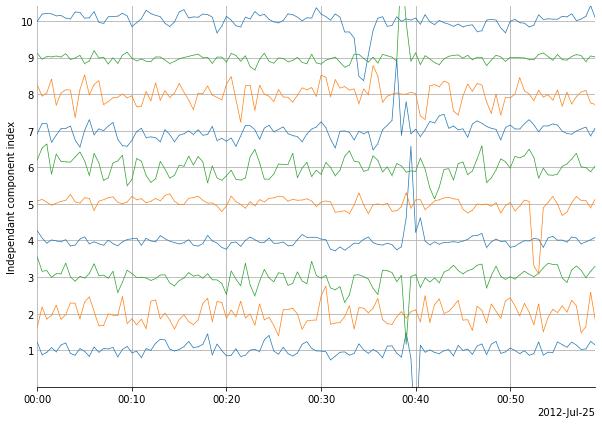

In [46]:
#features = latents
FACTOR=0.4
MEDFILT_KERNEL=1

# Show in time

# Preprocess
features = features.T
features = demad(features)
n_features, n_bins = features.shape

# Figure
fig, ax = plt.subplots(1, figsize=(10, 7))

# Show
for index, feature in enumerate(features):
    color = f"C{index % 3}"
    feature += index + 1
    feature_filtered = medfilt(feature, MEDFILT_KERNEL)
    ax.plot(times, feature, ".", ms=1, alpha=0.5, mew=0, color=color)
    ax.plot(times, feature_filtered, lw=0.7, color=color)

# Labels
ax.grid()
ax.set_ylim(0, n_features + FACTOR)
ax.set_yticks(np.arange(n_features) + 1)
ax.set_ylabel("Independant component index")

# Date labels
dateticks = mdates.AutoDateLocator()
datelabels = mdates.ConciseDateFormatter(dateticks)
ax.xaxis.set_major_locator(dateticks)
ax.xaxis.set_major_formatter(datelabels)
ax.set_xlim(times.min(), times.max())

# Remove borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis="y", length=0)

plt.show()

In [ ]:
CMAP=nmmn.plots.wolframcmap()
NBINS=800

# Show in latent space

# Preprocess
features = features.T
features = demad(features)
n_features = features.shape[0] - 1

# Figure
figsize = 2 * [n_features]
gridspec_kw = dict(hspace=0.1, wspace=0.1)
fig, ax = plt.subplots(
    n_features,
    n_features,
    figsize=figsize,
    gridspec_kw=gridspec_kw,
    constrained_layout=False,
    sharex="col",
    sharey="row",
)

# Versus diagrams
for i in range(n_features):

    x = features[i]
    x_min, x_max = x.min(), x.max()
    x_bins = np.linspace(x_min, x_max, nbins)

    for j in range(0, n_features):

        y = features[j + 1]
        y_min, y_max = y.min(), y.max()
        y_bins = np.linspace(y_min, y_max, NBINS)

        # Lower triangular
        if j >= i:

            # Histogram
            counts, _, _ = np.histogram2d(x, y, (x_bins, y_bins))
            counts = counts.T
            counts[counts == 0] = 1e-4
            counts = np.log(counts)
            extent = [x_min, x_max, y_min, y_max]
            ax[j, i].imshow(
                counts, cmap=CMAP, extent=extent, aspect="auto"
            )
            ax[j, i].grid()
            ax[j, i].set_xticks([])
            ax[j, i].set_yticks([])
            ax[j, i].set_ylim(y_min, y_max)
            ax[j, i].set_xlim(x_min, x_max)

            # Style
            for side in ax[j, i].spines:
                ax[j, i].spines[side].set_visible(False)

        # Upper triangular
        else:
            ax[j, i].set_axis_off()

        # Labels
        if j == n_features - 1:
            ax[j, i].set_xlabel(f"Latent {i + 1}")
        if i == 0:
            ax[j, i].set_ylabel(f"Latent {j + 2}")

plt.show()

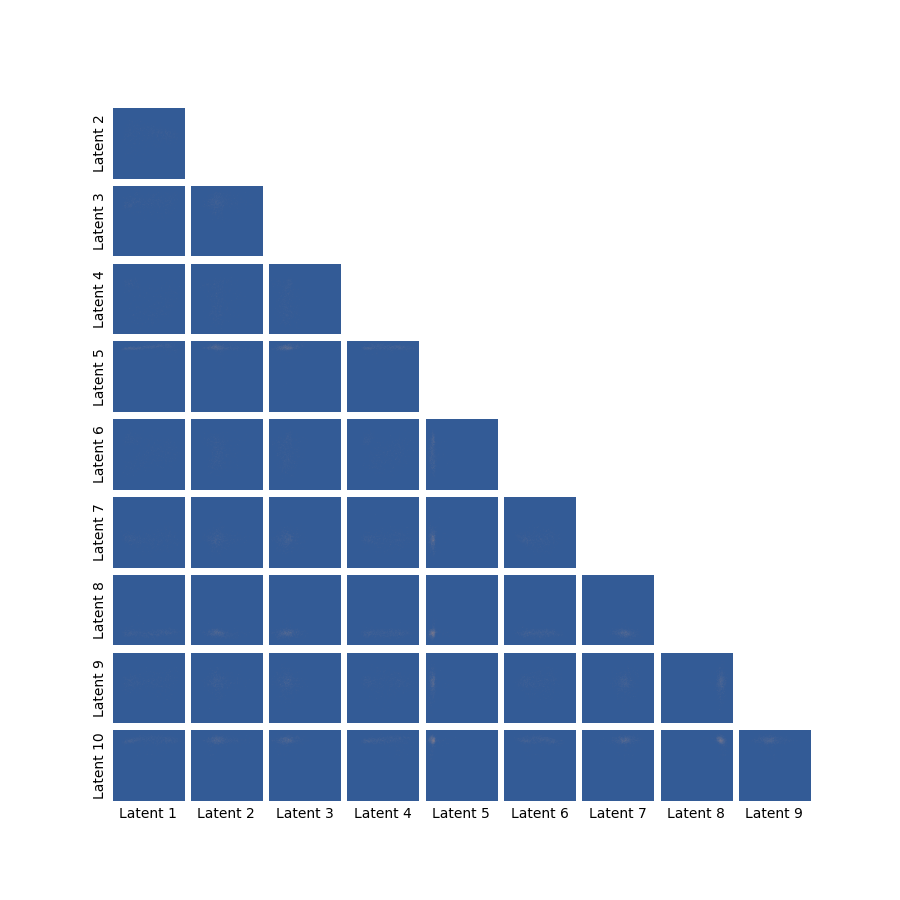